# 3D Tomography Experiments

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx
from utils import add_ball_to_array, get_cw_data, region_to_mua, get_td_data, detweight

### medium geometry

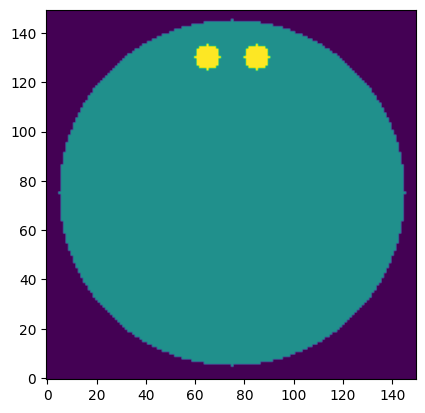

In [5]:
# number of voxels in each dimension
nx = 150
ny = 150
nz = 1 # 2d
r_head = 70 # head radius

# background
region = np.zeros((nz, ny, nx))

# head
region = add_ball_to_array(region, (nz//2, ny // 2, nx//2), r_head, 1)

# add balls
depth = 10 # mm (note this is the depth to the center of the ball)
separation = 10 # mm
r_ball = 5 # ball radius (mm)

region = add_ball_to_array(region, (nz//2, 130, nx//2 - np.floor(separation)), r_ball, 2)
region = add_ball_to_array(region, (nz//2, 130, nx//2 + np.ceil(separation)), r_ball, 2)

plt.imshow(region[nz//2])
plt.gca().invert_yaxis()
plt.show()

### sensor geometry

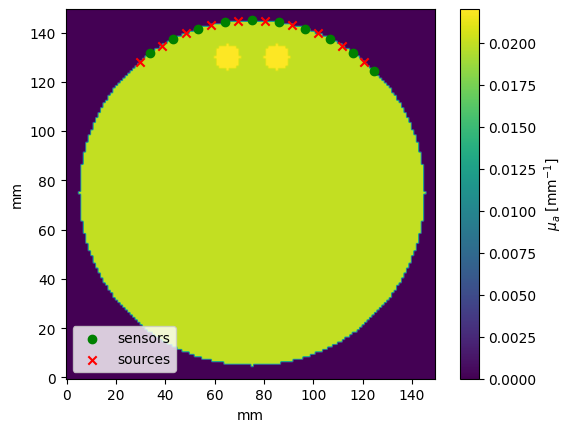

In [6]:
noptodes = 10 # number of optodes (this equates to roughly 1cm spacing)
sensor_positions = np.zeros((noptodes, 2))
source_positions = np.zeros((noptodes, 2))

# Create an array of i values
i_values = np.arange(noptodes)

# Calculate phi for q and m
phi_sensors = i_values / noptodes * np.pi / 2 + np.pi / 4
phi_sources = (i_values + 0.5) / noptodes * np.pi / 2 + np.pi / 4

# Calculate sensor and source positions
scaling_factor = 1

center_point = np.array([ny // 2, nx // 2])
sensor_positions  = scaling_factor * r_head * np.vstack((np.sin(phi_sensors), np.cos(phi_sensors))).T + center_point
source_positions  = r_head * np.vstack((np.sin(phi_sources), np.cos(phi_sources))).T + center_point
source_directions = center_point - source_positions
source_directions = source_directions / np.linalg.norm(source_directions, axis=1)[:,None] # normalize

# add a column of zeros to cast as 3D
source_positions = np.hstack((nz//2*np.ones((noptodes, 1)), source_positions))
source_directions = np.hstack((np.zeros((noptodes, 1)), source_directions))
sensor_positions = np.hstack((nz//2*np.ones((noptodes, 1)), sensor_positions))
sensor_positions = np.hstack((sensor_positions, np.ones((noptodes, 1))))

# info about region
relative_change = 1.1

g = 0.9                    # anisotropy factor
mua0 = 0.02               # background absorption [1/mm]
mus0 = 0.67/(1-g)               # background scattering [1/mm]
mua1 = mua0 * relative_change # absorption of perturbation [1/mm]
mus1 = mus0 * relative_change # scattering of perturbation [1/mm]
refind = 1.4                # refractive index

optical_properties = np.array([
    [0,0,1,1],
    [mua0, mus0, g, refind],
    [mua1, mus1, g, refind]
    ])

mua = region_to_mua(region, optical_properties)

plt.figure()
plt.imshow(mua[nz//2,...])
plt.colorbar(label="$\\mu_a \\text{ }[\\text{mm}^{-1}]$")
plt.scatter(sensor_positions[:,-2], sensor_positions[:,-3], c='g', marker='o', label='sensors')
plt.scatter(source_positions[:,-1], source_positions[:,-2], c='r', marker='x', label='sources')
plt.gca().invert_yaxis()
plt.xlabel("mm"); plt.ylabel("mm")
plt.legend()
plt.show()

## Forward

In [7]:
def forward(volume, optical_properties, source_positions, source_directions, 
            detector_positions):
    """
    Implements the forward monte carlo solver.
    """

    config = {
        'nphoton': 1e7,
        'vol': volume,
        'tstart': 0,
        'tend': 1e-8,
        'tstep': 5e-10,
        'srcpos': source_positions,
        'srcdir': source_directions,
        'prop': optical_properties,
        'detpos': detector_positions,
        'replaydet':-1,
        'issavedet': 1,
        'issrcfrom0': 1,
        'issaveseed': 1,
        # 'unitinmm': 1.8,
        # 'maxdetphoton': 1e10,
    }

    result = pmcx.mcxlab(config)
    return result, config

def compute_jacobian(forward_result, config):
    config['seed']       = forward_result['seeds']  # one must define config['seed'] using the returned seeds
    config['detphotons'] = forward_result['detp']['data']   # one must define config['detphotons'] using the returned detp data
    config['outputtype'] = 'jacobian'               # tell mcx to output absorption (μ_a) Jacobian

    result = pmcx.run(config)
    return result, config

In [21]:
source_index = 3

optical_properties_bg = np.array([
    [0,0,1,1],
    [mua0, mus0, g, refind],
    [mua0, mus0, g, refind] # set perturbation to background
    ])

mua_bg = region_to_mua(region, optical_properties_bg)

res_bg, cfg_bg = forward(region, optical_properties_bg, source_positions[source_index], source_directions[source_index], sensor_positions)
res_true, cfg_true = forward(region, optical_properties, source_positions[source_index], source_directions[source_index], sensor_positions)

nphoton: 1e+07
tstart: 0
tstep: 5e-10
tend: 1e-08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 143.066, 91.3412, 1]
srcdir: [0, -0.97237, -0.233445, 0]
issavedet: 1


issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using J

In [9]:
res_jac, cfg_jac = compute_jacobian(res_bg, cfg_bg)

nphoton: 1e+07
tstart: 0
tstep: 5e-10
tend: 1e-08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 143.066, 91.3412, 1]
srcdir: [0, -0.97237, -0.233445, 0]
issavedet: 1
issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and r

In [10]:

J = res_jac['flux'] # Jacobian of shape (nz, ny, nx, nt, ndetectors)

# compare pertubation from Jacobian to the true pertubation
dmua = region_to_mua(region, optical_properties) - region_to_mua(region, optical_properties_bg)
dmua_reshaped = dmua[..., np.newaxis, np.newaxis]

dphi = -np.tensordot(J, dmua_reshaped, axes=([0,1,2], [0,1,2])) # beware negative sign
dphi = dphi.squeeze()

In [11]:
weights = detweight(res_bg['detp'], cfg_bg['prop'])

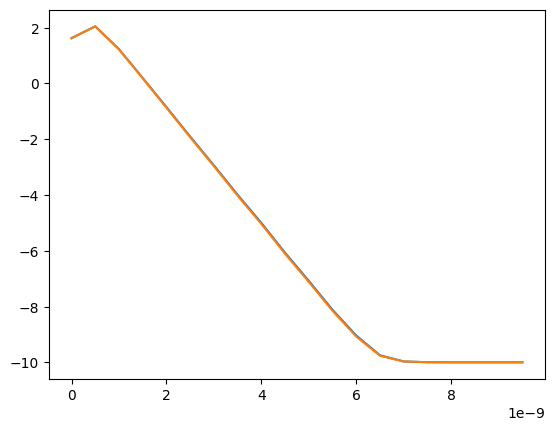

In [12]:
# # METHOD 1 for getting finite difference approximation
# intensity_bg = get_cw_data(res_bg, cfg_bg)
# intensity_true = get_cw_data(res_true, cfg_true)

# dphi_fd = (intensity_true - intensity_bg) / intensity_true

# METHOD 2 for getting finite difference approximation (using the same photons)
data_bg, t = get_td_data(res_bg, cfg_bg)
data_true, _ = get_td_data(res_bg, cfg_true)

cw_data_bg = np.sum(data_true, axis=0)[np.newaxis, :]
dphi_fd = (data_true - data_bg) / cw_data_bg

# intensity_bg = get_cw_data(res_bg, cfg_bg)
# intensity_true = get_cw_data(res_bg, cfg_true) # note we use res_bg here too

# dphi_fd = (intensity_true - intensity_bg) / intensity_true
# for i in range(noptodes):
plt.plot(t, np.log10(data_bg[:,0] + 1e-10))
plt.plot(t, np.log10(data_true[:,0] + 1e-10))

## Inversion

In [32]:
from utils import invert
dmua = invert(dphi_fd, mua_bg, J)
mua_new = mua_bg + dmua

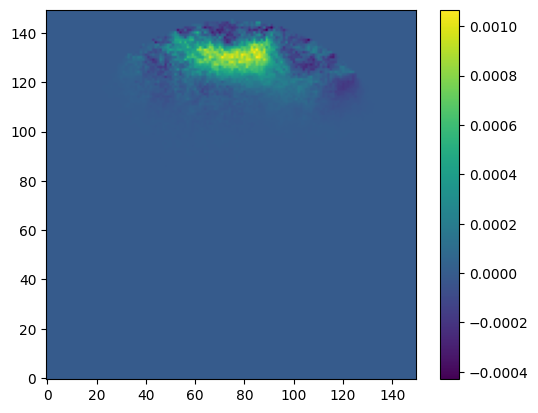

In [35]:
plt.imshow(dmua[nz//2,...])
plt.colorbar()
# flip y axis
plt.gca().invert_yaxis()

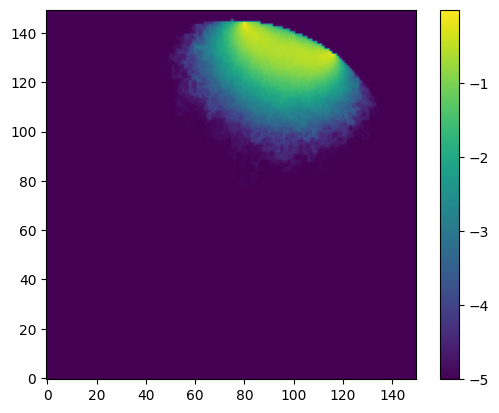

In [ ]:
plt.imshow((np.log10(res_jac['flux'][nz//2, :, :, 0,1]+1e-5)))
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()